# Human-like Visual Search Application with small data
<img src="assets/App.jpg" width="1600">

# Workshop materials

[GitHub repository](https://github.com/EzheZhezhe/Small_data_visual_search_app)

"**README.MD**" and  "**environment.yml**"

# Workshop structure

0. Introduction
1. Building blocks of Siamese Mask R-CNN
2. Siamese Mask R-CNN single deployment with FastAPI
3. Known limitations and possible improvements

# 0.Introduction

## About me
**Alyona Galyeva**: [Principal Data Solutions Engineer at LINKIT](https://www.linkit.nl/en) and [Organiser at PyLadies Amsterdam](https://amsterdam.pyladies.com/)

Former Machine Learning Engineer

<img src="assets/PyLadies1.jpg" width="800">  <img src="assets/PyLadies2.jpg" width="800">  <img src="assets/PyLadies3.jpg" width="800">  <img src="assets/PyLadies4.png" width="800">

Feel free to contact me via LinkedIn: https://www.linkedin.com/in/alyonagalyeva/


Before diving into the deepest depths of Siamese Mask R-CNN, let's briefly recap what are the common Computer Vision tasks

<img src="assets/ComputerVisionTasks.png" width="1000">

So, what is a Siamese neural network then?

<img src="assets/siamese.png" width="1000">




Wow, and what about Meta-learning?

<img src="assets/Meta.jpg" width="1000">

# 1.Building blocks of Siamese Mask R-CNN



In [1]:
# Inevitable step to download all required libraries

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext dotenv
%dotenv

import os
import random
import sys

import imgaug
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
sess_config = tf.ConfigProto()

COCO_DATA = os.getenv("COCO_DATA")
MASK_RCNN_MODEL_PATH = os.getenv("MASK_RCNN_MODEL_PATH")
MODEL_DIR = os.getenv("MODEL_DIR")

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
    
from samples.coco import coco

from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config



Using TensorFlow backend.


### MSCOCO Dataset

**What is MSCOCO?**

COCO is a large-scale object detection, segmentation, and captioning dataset. COCO has several features:

* Object segmentation
* Recognition in context
* Superpixel stuff segmentation
* 330K images (>200K labeled)
* 1.5 million object instances
* 80 object categories
* 91 stuff categories
* 5 captions per image
* 250,000 people with keypoints

In [2]:
# define categories that belong to one_shot_classes:
one_shot_classes = np.array([4*i + 1 for i in range(20)])

<img src="assets/CategoriesSplit.png" width="1400">

In [3]:
# Index COCO/val dataset
coco_val = siamese_utils.IndexedCocoDataset()
coco_object = coco_val.load_coco(COCO_DATA, subset="val", year="2017", return_coco=True)
coco_val.prepare()
coco_val.build_indices()
coco_val.ACTIVE_CLASSES = one_shot_classes

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


### Model

<img src="assets/siamese-mask-rcnn.png" width="1000">

In [4]:
class SmallEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1

class LargeEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 150
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100

In [5]:
#Let's pick a model size

model_size = 'large'
#model_size = 'small'

In [6]:
#Let's create config based on the chosen model size
if model_size == 'small':
    config = SmallEvalConfig()
elif model_size == 'large':
    config = LargeEvalConfig()
    
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CHECKPOINT_DIR                 checkpoints/
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
EXPERIMENT                     evaluation
FPN_CLASSIF_FC_LAYERS_SIZE     1024
FPN_FEATUREMAPS                256
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
LOSS_WEIGHTS                   {'rpn_class_loss': 2.0, 'rpn_bbox_loss': 0.1, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_los

In [7]:
#Select checkpoints
if model_size == 'small':
    checkpoint = 'checkpoints/small_siamese_mrcnn_0160.h5'
elif model_size == 'large':
    checkpoint = 'checkpoints/large_siamese_mrcnn_0320.h5'

In [ ]:
# Let's see what is under the hood

## Home assignment

Investigate the [original article](https://arxiv.org/pdf/1811.11507.pdf) and the source code in `/lib` folder and think over what can be improved and optimized for better performance

# 2.Siamese Mask R-CNN single deployment


Welcome to the world of machine learning engineering

<img src="assets/mlpipline.png" width="1000">

## CPU vs GPU deployment

<img src="assets/cpuvsgpu.png" width="1000">

### The idea of visual search

In [8]:
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint)

loading checkpoints/large_siamese_mrcnn_0320.h5 ...
starting from epoch 320


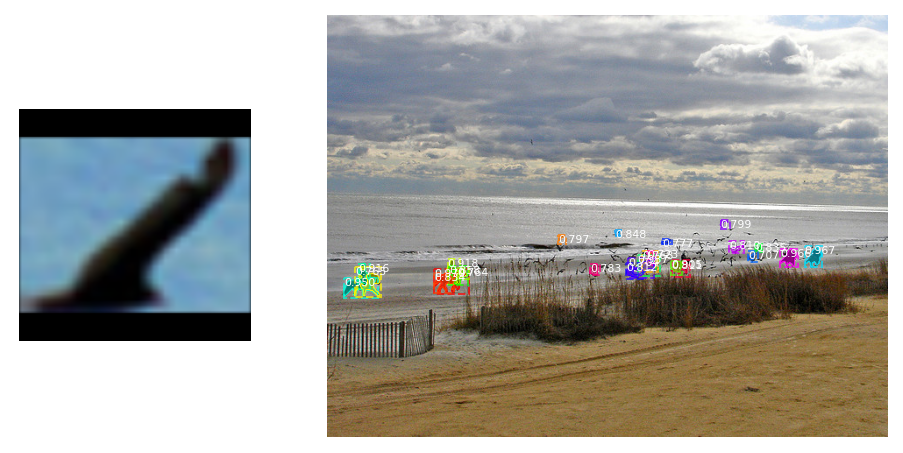

In [9]:
# Select category
category = 15
image_id = np.random.choice(coco_val.category_image_index[category])
# Load target
target = siamese_utils.get_one_target(category, coco_val, config)
# Load image
image = coco_val.load_image(image_id)

# Run detection
results = model.detect([[target]], [image], verbose=0)
r = results[0]
# Display results
siamese_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['scores'])

### Let's start building our first API with [FastAPI](https://fastapi.tiangolo.com/)

Open main.py and api/settings.py files


## Home assignment

Share some ideas on how to improve our API. Hint: security, cache, routers, validation schema

# 3.Known limitations and possible improvements

**Known limitations:**
- computationaly expensive
- cluttered scenes are especially challenging for one-shot tasks
- false positives biased toward the most frequent training categories in the training set
- a marked drop in model performance on novel categories 


**Possible improvements:**
- re-training in a more light-weighted manner
- codebase refactoring
- pruning and quantization
- training on novel datasets


## Home assignment

1. Let's play and retrain this model on new datasets, share your results
2. Try other meta learning techniques, especially Zero-shot learning
3. Find a suitable model to build a basic metasearch app  




## Bonus

2 checklists for Modelling and Deployment. Share with you colleagues

**Modelling checklist** 

1. What is our model metric and business metric? Are they same or different?

2. Will more data improve the metrics? Can we get more data?

3. Have we used fp16 and multi-GPU for reducing training time? Have we optimised batch size and tried one_cycle_fit for reducing training time? Are we using Adam, Radam, ranger or a new optimiser?

4. If the problem was solved with deep learning, have we tried enough classical approaches? What’s the difference in metric and inference time between classical and DL?

5. Is the model hyper-tuned manually or algorithmically? Will we need hypertuning layer for retraining? Is the data changing rapidly with time and will the current model parameters be enough down the line?

6. What is the difference between train, validation and test metrics?

7. Have the data scientist and domain experts done error analysis?

8. Can we try interpretability? Have we tried interpretability on errors?

9. Is there a pattern in the mistakes of the model? Can it be solved with a postprocessing layer or a new feature?

10. Is manual intervention needed after prediction and client usage? How can it be reduced?

**Deployment checklist** 

1. Have we backed code, data and metrics with the model and encoders?

2. Have we checked opportunities for caching?

3. Have we defined a realistic load test as per traffic? If the peak load seems rare, can we design for mean traffic and let the failed request to be retried?

4. Are we serving with flask, WSGI, uWSGI or gunicorn?

5. Have we done cache, worker and thread sizing? (Do not blindly go with gunicorn’s 2n+1 advice on workers. Test everything empirically)

6. Have we tackled all edge cases for incoming data in request?

7. Are the fields in inference DB kept in accordance with the incoming data? Can inference DB error cause response error?

8. Are we sending appropriate messages/flags in response to debug errors coming from the client?

9. Should we deploy on CPU or GPU? Which components require GPU and why?

10. What are the bottlenecks in the prediction pipeline? Can we isolate them out?

11. Can we keep all models in a single docker image? It’s a tradeoff between flexibility, simplicity and cost reduction

12. Can we go serverless for deployment? 

13. Do we have a model rollback plan?

14. Is data going to change or increase with time? Is retraining of our models needed? Have we planned it in the total project planning?

15. Is the code and deployment pipeline flexible enough to be used for retraining with minimal changes?

16. How will you analyse the model performance in production? How frequently will the reports be generated?


Both checklists are part of the Medium article [Productionizing NLP Models](https://medium.com/modern-nlp/productionizing-nlp-models-9a2b8a0c7d14) written by Pratik Bhavsar

# Thank you for your attention!

